In [266]:
import pyspark.sql
from pyspark.sql.functions import col, count, sum, isnan,  to_timestamp, mean, max, min, expr, when
import matplotlib.pyplot as plt
import seaborn as sns

In [176]:
from pyspark.sql import SparkSession

In [177]:
# Creating a pasrk session
spark = SparkSession.builder.getOrCreate()

In [178]:
# Reading csv file
df = spark.read.csv("./yellow_taxi_trips/yellow_trips.csv", header=True, inferSchema=True)


In [179]:
# Setting max number of rows to be displayed 
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", "1000")

In [180]:
# Showing 20 rows 
df.show(n=20, truncate=False)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|1       |2022-04-01 00:21:13 |2022-04-01 00:58:33  |1.0            |10.3         |1.0       |N                 |163         |62          |1           |33.5       |3.0  |0.5    |7.45     

# Checking for constant columns  - number of unique values in each column

In [181]:
for column in df.columns:
    unique_values = df.select(column).distinct().count()
    print(f"{column} has {unique_values} unique values")

VendorID has 4 unique values


tpep_pickup_datetime has 23255707 unique values


tpep_dropoff_datetime has 23243720 unique values


passenger_count has 11 unique values


trip_distance has 8985 unique values


RatecodeID has 8 unique values


store_and_fwd_flag has 3 unique values


PULocationID has 262 unique values


DOLocationID has 262 unique values


payment_type has 6 unique values


fare_amount has 14604 unique values


extra has 234 unique values


mta_tax has 48 unique values


tip_amount has 7341 unique values


tolls_amount has 2491 unique values


improvement_surcharge has 5 unique values


total_amount has 28924 unique values


congestion_surcharge has 11 unique values


airport_fee has 5 unique values


# Dropping irrelevant and constant colums

In [182]:
# Dropping columns in list of columns to drop 
columns_to_drop = ["VendorID","RatecodeID","store_and_fwd_flag","payment_type","fare_amount","extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge","total_amount","congestion_surcharge","airport_fee"]
df = df.drop(*columns_to_drop)




In [183]:
# Checking data types 
df.dtypes

[('tpep_pickup_datetime', 'string'),
 ('tpep_dropoff_datetime', 'string'),
 ('passenger_count', 'double'),
 ('trip_distance', 'double'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int')]

# Checking shape of data set

In [184]:
rows = df.count()
columns = len(df.columns)

print(f"There are {rows} rows and {columns} columns total  in this data set")

There are 46576654 rows and 6 columns total  in this data set


# Filtering for Manhattan Locations

## Unique Locations

### Pickups

In [277]:
# Selecting all the distinct values in the pickup location column
pickup = "PULocationID"  
num_unique_pickups = df.select(pickup).distinct().count()

print(f"{pickup} has {num_unique_pickups} unique values.")

PULocationID has 262 unique values.


### Drop offs

In [188]:
# Selecting all the distinct values in the pickup locationcolumn
dropoff = "DOLocationID"
num_unique_dropoffss = df.select(dropoff).distinct().count()


print(f"{dropoff} has {num_unique_dropoffss} unique values.")

DOLocationID has 262 unique values.


- Pickup and Drop off columns do not exceed the number of unique values permitted 

## Manhattan Zones

In [278]:
# List of manhattan taxi zones 
manhattan = [4,24,12,13,41,45,42,43,48,50,68,79,74,75,87,88,90,125,100,103,107,113,114,116,120,127,128,151,140,137
             ,141,142,152,143,144,148,153,158,161,162,163,164,170,166,186,194,202,209,211,224,229,230,231,239,232
             ,233,234,236,237,238,243,244,246,249,261,262,263]

In [279]:
print(len(manhattan))

67


### Checking how many pickups are in Manhattan

In [280]:
manhattan_PUloc = df.filter(col("PULocationID").isin(manhattan))

In [281]:
manhattan_rows = manhattan_PUloc.count()
manhattan_columns = len(df.columns)

print(f"There are {manhattan_rows} rows and {manhattan_columns} Manhattan pick up columns ")

There are 41388431 rows and 6 Manhattan pick up columns 


### Checking how many drop offs are in Manhattan

In [197]:
manhattan_DOloc = df.filter(col("DOLocationID").isin(manhattan))

In [198]:
manhattan_DOrows = manhattan_DOloc.count()
manhattan_DOcolumns = len(df.columns)

print(f"There are {manhattan_DOrows} rows and {manhattan_DOcolumns} Manhattan drop off columns")

There are 41141402 rows and 6 Manhattan drop off columns


- More pick ups in manhattan, therefore, pickups could be a better indicator of busyness since it means people are coming into Manhattan

### Filtering for rows with drop offs or pick ups in Manhattan

In [282]:
manhattan_df = df.filter((col("PULocationID").isin(manhattan)) | (col("DOLocationID").isin(manhattan)))

# Saving the rows with pickup or dropoffs in Manhattan to a new CSV file

## Source for how to save dataframe as a CSV file 
- https://sparkbyexamples.com/pyspark/pyspark-write-dataframe-to-csv-file/#:~:text=In%20PySpark%20you%20can%20save,any%20PySpark%20supported%20file%20systems.

In [283]:
manhattan_df.write.option("header", "true").mode("overwrite").csv("./manhattan_yellowtaxis.csv")

## New Spark session with filtered csv

In [285]:
manhattan_spark = SparkSession.builder.getOrCreate()

In [286]:
# Load the CSV file
manhattan_df = manhattan_spark.read.csv("./manhattan_yellowtaxis.csv", header=True, inferSchema=True)


In [287]:
manhattan_spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", "1000")

In [288]:
manhattan_df.show(n=20, truncate=False)

+--------------------+---------------------+---------------+-------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|
+--------------------+---------------------+---------------+-------------+------------+------------+
|2022-02-01 00:06:48 |2022-02-01 00:33:07  |1.0            |12.16        |138         |125         |
|2022-02-01 00:57:23 |2022-02-01 01:07:31  |2.0            |2.3          |140         |142         |
|2022-02-01 00:34:17 |2022-02-01 01:01:32  |1.0            |7.5          |140         |36          |
|2022-02-01 00:03:26 |2022-02-01 00:07:30  |1.0            |0.88         |48          |68          |
|2022-02-01 00:13:31 |2022-02-01 00:31:41  |1.0            |6.48         |142         |244         |
|2022-02-01 00:52:11 |2022-02-01 01:02:48  |1.0            |3.29         |238         |116         |
|2022-02-01 00:57:53 |2022-02-01 01:01:15  |0.0            |0.7          |143         |163 

In [289]:
filtered_df.dtypes

[('tpep_pickup_datetime', 'string'),
 ('tpep_dropoff_datetime', 'string'),
 ('passenger_count', 'double'),
 ('trip_distance', 'double'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int')]

# Checking Unique Locations

## Pickups 

In [290]:
pickup = "PULocationID"  
num_unique_values = manhattan_df.select(pickup).distinct().count()

print(f"{pickup} has {num_unique_values} unique values.")

PULocationID has 262 unique values.


## Drop offs

In [291]:
dropoff = "DOLocationID"
num_unique_values = manhattan_df.select(dropoff).distinct().count()


print(f"{dropoff} has {num_unique_values} unique values.")

DOLocationID has 261 unique values.


## Checking the shape of new data frame

In [292]:
total_rows = manhattan_df.count()
total_columns = len(manhattan_df.columns)

print(f"There are {total_rows} rows and {total_columns} columns total  in this data set")

There are 44132589 rows and 6 columns total  in this data set


### The filter was successful

## Number of null values in each column

In [293]:
for column in manhattan_df.columns:
    null_count = manhattan_df.filter(col(column).isNull()).count()
    print(f"{column} has {null_count} null values")

tpep_pickup_datetime has 0 null values


tpep_dropoff_datetime has 0 null values


passenger_count has 1443046 null values


trip_distance has 0 null values


PULocationID has 0 null values


DOLocationID has 0 null values


## Number of NaN values in each column

In [294]:
for column in manhattan_df.columns:
    nan_count = manhattan_df.filter(isnan(col(column))).count()
   
    print(f"{column} has {nan_count} NaN values")

tpep_pickup_datetime has 0 NaN values


tpep_dropoff_datetime has 0 NaN values


passenger_count has 0 NaN values


trip_distance has 0 NaN values


PULocationID has 0 NaN values


DOLocationID has 0 NaN values


# Analysis of passenger_count column

## Percentage of null rows

In [295]:
null_count = manhattan_df.filter(col("passenger_count").isNull()).count()
total_rows = manhattan_df.count()

null_percentage = (null_count / total_rows) * 100
print(f"The percentage of null rows in the passenger_count column is {null_percentage}%")

The percentage of null rows in the passenger_count column is 3.2697968387941168%


- Only passenger_count has null values. No rows have NaN values

## Checking for irregular values in passenger_count

In [299]:
irregular_passengers = [9.0, 8.0, 7.0, 0.0]


In [300]:
passenger_count = manhattan_df.groupBy("passenger_count").count()

specific_value_counts = passenger_count.filter(col("passenger_count").isin(irregular_passengers))

specific_value_counts.show()

+---------------+------+
|passenger_count| count|
+---------------+------+
|            8.0|    73|
|            0.0|824011|
|            7.0|   109|
|            9.0|    22|
+---------------+------+



## Percentage with irregular values 

In [301]:
total_irregular = manhattan_df.filter(col("passenger_count").isin(irregular_passengers)).count()

total_rows = manhattan_df.count()

irregular_percentage = (total_irregular / total_rows) * 100

print(f"The percentage of rows with irregular values in the passenger_count column is {irregular_percentage}%")


The percentage of rows with irregular values in the passenger_count column is 1.8675881444435538%


## Checking for passenger _count outliers using plots

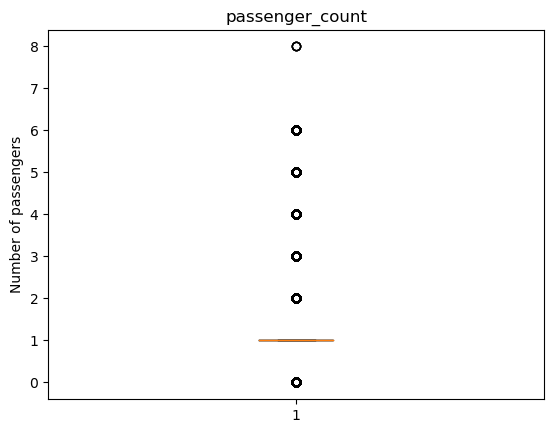

In [302]:
## Converting to a pandas data frame using the first 500,000 rows 
passenger_pandas = manhattan_df.select("passenger_count").limit(500000).toPandas()["passenger_count"]

# box plot
plt.boxplot(passenger_pandas)

plt.title("passenger_count")
plt.ylabel("Number of passengers")
plt.xlabel("Frequency")

plt.show()

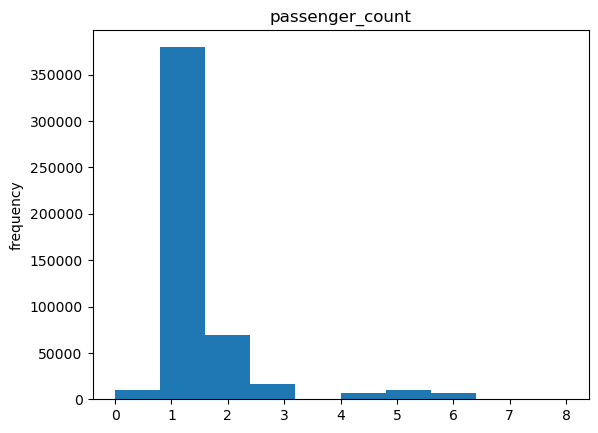

In [303]:
# Histogram
plt.hist(passenger_pandas)


plt.title("passenger_count")
plt.ylabel("frequency")

plt.show()

# Analysing Trip distance column

In [305]:
# Checking min, max and mean values

distance_calculations = manhattan_df.agg(
    min("trip_distance").alias(f"Min_trip_distance"),
    max("trip_distance").alias(f"Max_trip_distance"),
    mean("trip_distance").alias(f"Mean_trip_distance")
)

distance_calculations.show()


+-----------------+-----------------+------------------+
|Min_trip_distance|Max_trip_distance|Mean_trip_distance|
+-----------------+-----------------+------------------+
|              0.0|        389678.46| 5.273092328437697|
+-----------------+-----------------+------------------+



# Number of rows with min and max distance

In [306]:
min_max_distance = [0.0,389678.46]

In [307]:
value_counts = manhattan_df.groupBy("trip_distance").count()

specific_value_counts = value_counts.filter(col("trip_distance").isin(min_max_distance))

specific_value_counts.show()

+-------------+------+
|trip_distance| count|
+-------------+------+
|          0.0|428295|
|    389678.46|     1|
+-------------+------+



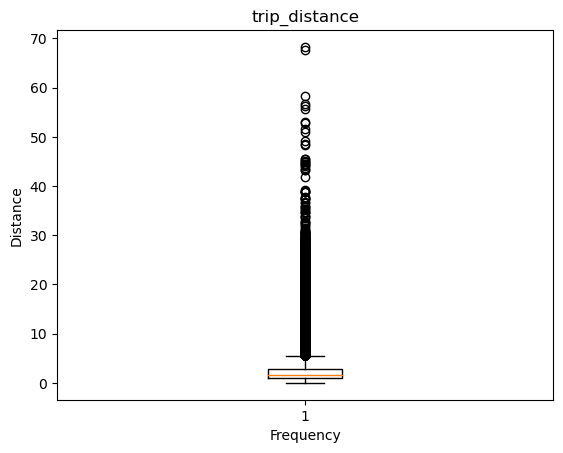

In [309]:
# Converting to a pandas datafram using the first 500,000 values 
distance_pandas = manhattan_df.select("trip_distance").limit(500000).toPandas()["trip_distance"]

# box plot
plt.boxplot(distance_pandas)

plt.title("trip_distance")
plt.ylabel("Distance")
plt.xlabel("Frequency")
plt.show()

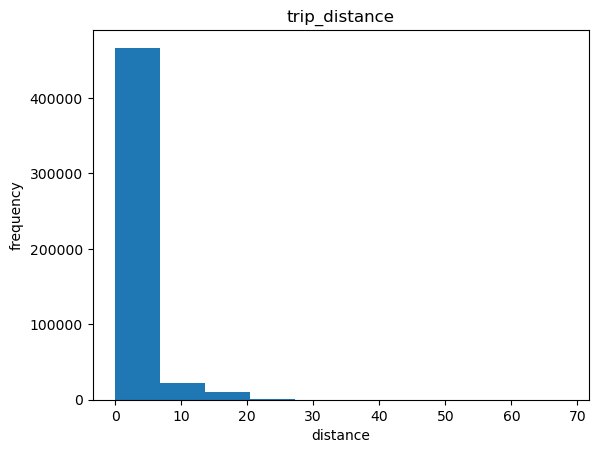

In [310]:
# plotting histogram
plt.hist(distance_pandas)


plt.title("trip_distance")
plt.ylabel("frequency")
plt.xlabel("distance")

plt.show()

- Based on the plots, most of the trip distance is within 30 miles 

## Number of trips with distances over 30 miles

In [312]:
# calculating the number of trips over 30 miles
trip_distance = "trip_distance" 
long_distance = manhattan_df.filter(col(trip_distance) > 30)

long_distance_count = long_distance.count()

print(f"The number of rows with {trip_distance} over 30 miles  is: {long_distance_count}")


The number of rows with trip_distance over 30 miles  is: 9090


## Percentage of trips over 30 miles 

In [313]:
long_distance_percentage = (long_distance_count/total_rows) * 100
print(f"The percentage of trips over 30 miles is {long_distance_percentage}%")

The percentage of trips over 30 miles is 0.020597024117483795%


# Analysing Pickup and Drop off times 

## Converting pickup and drop offs to timestamp
- completed using source below
- https://sparkbyexamples.com/spark/pyspark-to_timestamp-convert-string-to-timestamp-type/

- This column is in yyyy-MM-dd HH:mm:ss format 

In [314]:
manhattan_df = manhattan_df.withColumn("tpep_pickup_datetime",to_timestamp("tpep_pickup_datetime","yyyy-MM-dd HH:mm:ss"))
manhattan_df = manhattan_df.withColumn("tpep_dropoff_datetime",to_timestamp("tpep_dropoff_datetime","yyyy-MM-dd HH:mm:ss"))





In [315]:
manhattan_df.dtypes

[('tpep_pickup_datetime', 'timestamp'),
 ('tpep_dropoff_datetime', 'timestamp'),
 ('passenger_count', 'double'),
 ('trip_distance', 'double'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int')]

## Pickup min and max timestamps

In [316]:
pickup_time = "tpep_pickup_datetime"


pickup_min_max = manhattan_df.agg(
    min(pickup_time).alias(f"Min_{pickup_time}"),
    max(pickup_time).alias(f"Max_{pickup_time}")
)


pickup_min_max.show()

+------------------------+------------------------+
|Min_tpep_pickup_datetime|Max_tpep_pickup_datetime|
+------------------------+------------------------+
|     2001-01-01 00:03:14|     2023-04-18 14:30:05|
+------------------------+------------------------+



## Drop off min and max timestamps

In [317]:
dropoff_time = "tpep_dropoff_datetime"


dropoff_min_max = manhattan_df.agg(
    min(dropoff_time).alias(f"Min_{dropoff_time}"),
    max(dropoff_time).alias(f"Max_{dropoff_time}")
)


pickup_min_max.show()

+------------------------+------------------------+
|Min_tpep_pickup_datetime|Max_tpep_pickup_datetime|
+------------------------+------------------------+
|     2001-01-01 00:03:14|     2023-04-18 14:30:05|
+------------------------+------------------------+



## Checking how many rows that have permitted date time values

In [318]:
# Correct date time range 
start_datetime = "2022-01-01 00:00:00"
end_datetime = "2023-03-10 23:59:59"

In [319]:
jan_mar23 = manhattan_df.filter(
    (col("tpep_pickup_datetime") >= start_datetime) & (col("tpep_pickup_datetime") <= end_datetime) &
    (col("tpep_dropoff_datetime") >= start_datetime) & (col("tpep_dropoff_datetime") <= end_datetime)
)

permitted_rows = jan_mar23.count()

print(f"There are {permitted_rows} rows within permitted date range this data set ")


There are 41985075 rows within permitted date range this data set 


## Checking how many rows are not within permitted range 

In [320]:
incorrect_date = manhattan_df.filter(
    ~(
        (col("tpep_pickup_datetime") >= start_datetime) & (col("tpep_pickup_datetime") <= end_datetime) &
        (col("tpep_dropoff_datetime") >= start_datetime) & (col("tpep_dropoff_datetime") <= end_datetime)
    )
)

incorrect_rows = incorrect_date.count()

print(f"There are {incorrect_rows} rows with the inccorrect date in this data set ")


There are 2147514 rows with the inccorrect date in this data set 


## Percentage of rows with incorrect date time values

In [321]:
incorrect_date_percentage = (incorrect_rows/total_rows) * 100
print(f"The percentage of rows with incorrect pickup and drop off times is {incorrect_date_percentage}%")

The percentage of rows with incorrect pickup and drop off times is 4.8660503466044105%


# Addressing rows with Data Quality Issues

## Drop off and pickup times 

- These rows will be removed. They cannot be replaced the mean because it can't be calculated due to the data type. Replacing with the mode or median may introduce bias for a certain day and time which can have an impact on the model since the rows outside of the permitted date and time range make up almost 5% of the data set

### Removing rows outside the permitted range

In [323]:
manhattan_df =  manhattan_df.filter(
    (col("tpep_pickup_datetime") >= start_datetime) & (col("tpep_pickup_datetime") <= end_datetime) &
    (col("tpep_dropoff_datetime") >= start_datetime) & (col("tpep_dropoff_datetime") <= end_datetime)
)


In [324]:
#checking the number of rows remaining to ensure that filter was aplied
manhattan_df.count()

41985075

In [327]:
# Checking that datetime filter was applied
datetime_min_max = manhattan_df.agg(
min("tpep_pickup_datetime").alias(f"Min_pickup_time"),
min("tpep_dropoff_datetime").alias(f"Min_dropoff_time"),
max("tpep_pickup_datetime").alias(f"Max_pickup_time"),
max("tpep_dropoff_datetime").alias(f"Max_dropoff_time")
                                   )
datetime_min_max.show()

+-------------------+-------------------+-------------------+-------------------+
|    Min_pickup_time|   Min_dropoff_time|    Max_pickup_time|   Max_dropoff_time|
+-------------------+-------------------+-------------------+-------------------+
|2022-01-31 23:01:03|2022-01-27 11:53:18|2023-03-10 23:59:43|2023-03-10 23:59:59|
+-------------------+-------------------+-------------------+-------------------+



## Trip distance

- Rows over 30 miles will be dropped since they make up of an insignificant portion of the data (less than 1%)

In [328]:
manhattan_df = manhattan_df.filter(col("trip_distance") <= 30)

In [329]:
#checking the number of rows remaining to ensure that filter was aplied
manhattan_df.count()

41976473

In [330]:
# Checking the min, max and mean distance of filetered data frame
distance_calculations = manhattan_df.agg(
min("trip_distance").alias(f"Min_trip_distance"),
max("trip_distance").alias(f"Max_trip_distance"),
mean("trip_distance").alias(f"Mean_trip_distance")
)

distance_calculations.show()

+-----------------+-----------------+------------------+
|Min_trip_distance|Max_trip_distance|Mean_trip_distance|
+-----------------+-----------------+------------------+
|              0.0|             30.0|  3.20531152438644|
+-----------------+-----------------+------------------+



## Passenger Count

### Removing irregular values 

- According to the source below there can be no more than 6 passengers in a yellow taxi
- https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page

In [331]:
manhattan_df = manhattan_df.filter(col("passenger_count")<=6)

In [332]:
# checking distinct values to ensure that filter was applied
manhattan_df.select("passenger_count").distinct().show()

+---------------+
|passenger_count|
+---------------+
|            0.0|
|            1.0|
|            4.0|
|            3.0|
|            2.0|
|            6.0|
|            5.0|
+---------------+



### Imputing null rows and rows with 0

- mean was caluclated using the source below
- https://linuxhint.com/mean-pyspark/

In [334]:
# calculating mean passenger count
mean_passenger = manhattan_df.filter((col("passenger_count") != 0) & (col("passenger_count").isNotNull())).agg(mean("passenger_count")).first()[0]
mean_passenger = round(mean_passenger)
print(f"The mean of the passenger_count column is {mean_passenger}")


The mean of the passenger_count column is 1


In [335]:
# Caluclating median  passenger count
passenger_median = manhattan_df.agg(expr("percentile(passenger_count, 0.5)").alias("Median")).first()["Median"]

print(f"The median of the passenger_count column is {passenger_median}")

The median of the passenger_count column is 1.0


In [336]:
# Calculating the mode passenger count
passenger_count = manhattan_df.groupBy("passenger_count").agg(count("passenger_count").alias("count"))

passenger_order = passenger_count.orderBy("count", ascending=False).first()

passenger_mode = passenger_order["passenger_count"]

print(f"The mode of the passenger_count column is {passenger_mode}")

The mode of the passenger_count column is 1.0


### Calculating the percentage of null values and rows with 0 in the passenger_count column again

In [337]:
# percentage of rows with 0 as a value
passenger_zero = manhattan_df.filter(col("passenger_count") == 0.0).count()
zero_percentage = (passenger_zero/total_rows) * 100
print(f"The percentage of rows with 0 is {zero_percentage}")

The percentage of rows with 0 is 1.7829590736224425


In [338]:
# percentage of null rows 
passenger_null = manhattan_df.filter(col("passenger_count").isNull()).count()
null_percentage = (passenger_null/total_rows)*100
print(f"The percentage of null passenger_count rows is {null_percentage}")

The percentage of null passenger_count rows is 0.0


- As shown above the percentage of rows with 0 has reduced and there are no more null rows. This can be attributed to the fact that some rows were removed to address other data quality issues
- The rows with 0 will be replaced with 1 since this is mode, median and mean passenger count as show above. 
- This was done because 1 passenger is smallest permitted value for this column so it will be used to replace the rows with 0 to preserve the data since almost 5% of data set was removed previously to address other data qualit issues 
- This may introduce some bias into the data however the number of rows with 0 as a value is less than 2% so this imputing unlikely to impact the prediction model.

### Replacing the 0 passenger rows with 1 
- The source of the code to replace values is given below
- https://sparkbyexamples.com/pyspark/pyspark-replace-column-values/?expand_article=1

In [339]:
manhattan_df = manhattan_df.withColumn("passenger_count", when(col("passenger_count") == 0, mean_passenger).otherwise(col("passenger_count")))


In [340]:
manhattan_df.select("passenger_count").distinct().show()

+---------------+
|passenger_count|
+---------------+
|            1.0|
|            4.0|
|            3.0|
|            2.0|
|            6.0|
|            5.0|
+---------------+



# Cleaned data frame shape

In [341]:
total_rows = manhattan_df.count()
total_columns = len(manhattan_df.columns)
print(f"There are {total_rows} rows and {total_columns} columns in this data set")

There are 40591283 rows and 6 columns in this data set


## Data Quality Summary
| Variable Names                     | Data Quality Issue            | Handling Strategy              |
|------------------------------------|-------------------------------|--------------------------------|
| RatecodeID                          | Irrelevant        | Drop column                   |
| store_and_fwd_flag                    | Irrelevant        | Drop column                       |
| payment_type                         | Irrelevant         | Drop column                       |
| fare_amount                  | Irrelevant        | Drop column                       |
| extra                          | Irrelevant|Drop column        |
| mta_tax                                | Irrelevant| Drop column         |
| tip_amount                               | Irrelevant| Drop column        |
| tolls_amount                          | Irrelevant| Drop column        |
| improvement_surcharge    | Irrelevant                     | Drop column|
| total_amount                | Irrelevant                      | Drop column|
| airport_fee                        | Irrelevant | Drop column                         |
| VendorID                     | Irrelevant, constant values |Drop column       |
| congestion_surcharge                            | Irrelevant|Drop column       |
| passenger_count                           |null rows, invalid values |Remove the rows with over 6.0 passengers since they don't even add up to 1000 rows, it won't have much of an impact data set. Fill in rows with 0 with 1|
| trip_distance                           |Outliers |Cut off distance at 30 miles as rows over this value do not up to 1% of data set so it won't have much of an impact  on the data set     |
| tpep_pickup_datetime         | Invalid values                    |Remove all with inccorect dates - Cannot calculate mean so can't be filled in with that value, can't be filled in with random values. Using next neigbour(previou value/ next value) could inflate busyness count
       |
| tpep_dropoff_datetime        | Inavlid values                   |Remove all with inccorect dates - Cannot calculate mean so can't be filled in with that value, can't be filled in with random values. Using next neigbour(previou value/ next value) could inflate busyness count
      |

